In [33]:
import numpy as np
import numba
from numba.types import *
from numba import prange
import matplotlib.pyplot as plt
from numpy.linalg import eig, multi_dot, inv
from numpy import sin
from numpy import pi
from scipy.optimize import curve_fit
from scipy.linalg import schur
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size']=20
from scipy.linalg import expm
from numpy.linalg import matrix_power
from scipy.stats import linregress
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import eval_genlaguerre, gamma, hyp1f1
from math import acos, factorial

In [34]:
S=150
dim=int(2*S+1)
τ=1
i=complex(0, 1)
basis = np.identity(dim)
#N_av=100

In [35]:
#Definition of the ladder operators
@numba.jit(numba.types.Tuple((float64, float64[:]))(float64[:], float64), nopython=True, fastmath=True, parallel=False)
def S_p(ket, S):
    site= np.argmax(ket)
    m=site-S
    ket_out=np.zeros(dim)
    if site== 2*S:
        coef=0
        return (coef, ket_out)
    else:
        coef=np.sqrt(S*(S+1)-m*(m+1))
        ket_out[site+1]= 1
        return (coef, ket_out)
@numba.jit(numba.types.Tuple((float64, float64[:]))(float64[:], float64), nopython=True, fastmath=True, parallel=False)
def S_m(ket, S):
    site= np.argmax(ket)
    m=site-S
    ket_out=np.zeros(dim)
    if site== 0:
        coef=0
        return (coef, ket_out)
    else:
        coef= np.sqrt(S*(S+1)-m*(m-1))
        ket_out[site-1]= 1
        return (coef, ket_out)

In [36]:
@numba.jit(float64(float64[:], float64[:]), nopython=True, fastmath=True, parallel=False)
def braket(bra, ket):
    if np.all(bra== ket):
        return 1
    else:
        return 0

In [37]:
@numba.jit(float64[:,:](float64[:, :], float64), nopython=True, fastmath=True, parallel=False)
def Compute_Sx(basis, S):
    dim=int(2*S+1)
    Sx=np.zeros((dim, dim))
    for j in range(dim):
        for k in range(dim):
            ket=basis[j, :]
            bra=basis[k, :]
            coef_p, S_p_ket=S_p(ket, S)
            coef_m, S_m_ket=S_m(ket, S)
            result_p=braket(bra, S_p_ket)
            result_m=braket(bra, S_m_ket)
            Sx[j, k]=(coef_p*result_p+ coef_m*result_m)/2
    return Sx

@numba.jit(complex128[:,:](float64[:, :], float64), nopython=True, fastmath=True, parallel=False)
def Compute_Sy(basis, S):
    dim=int(2*S+1)
    Sy=np.zeros((dim, dim), dtype=complex128)
    i=complex(0,1)
    for j in range(dim):
        for k in range(dim):
            ket=basis[j, :]
            bra=basis[k, :]
            coef_p, S_p_ket=S_p(ket, S)
            coef_m, S_m_ket=S_m(ket, S)
            result_p=braket(bra, S_p_ket)
            result_m=braket(bra, S_m_ket)
            Sy[j, k]=-i*(coef_p*result_p- coef_m*result_m)/2
    return Sy

@numba.jit(float64[:,:](float64), nopython=True, fastmath=True, parallel=False)
def Compute_Sz(S):
    dim=int(2*S+1)
    Sz=np.zeros((dim, dim))
    for j in range(dim):
        m=j-S
        Sz[dim-1-j, dim-1-j]=m
    return Sz
def BrodyDist(s, br):
    b=(gamma((br+ 2)/(br + 1)))**(br + 1)
    return (br + 1)*b*s**br*np.exp(-b*s**(br+1))
def unfoldSpectrum(E, order, n_bins, N):
    Emax=np.max(E)
    Emin=np.min(E)
    rhoE, bins=np.histogram(E, bins=np.linspace(Emin, Emax, n_bins+1), density='True')
    bins=bins[:-1]
    N_E=np.zeros(n_bins)
    dummyE=0
    dE=(bins[1]-bins[0])
    for k in range(n_bins):
        dummyE+=rhoE[k]*dE
        N_E[k]=dummyE
    fit=np.polyfit(bins, N_E, order)
    polyn=np.poly1d(fit)
    unf_E=N*polyn(E)
    rhoE_unf, bins=np.histogram(unf_E, bins=np.linspace(np.min(unf_E), np.max(unf_E), n_bins+1), density='True')
    stdrho=np.std(rhoE_unf)
    #plt.bar(bins[:-1], rhoE_unf, width=(bins[1]-bins[0]))
    #plt.hlines(1/N+2*stdrho, 0, N)
    #plt.hlines(1/N-2*stdrho, 0, N)
    #plt.show()
    ndiscard=np.sum(rhoE_unf>1/N+2*stdrho) # # bins with ρ(E)>1/N+2σ. # bins to discard
    #print(ndiscard)
    unf_E=unf_E[unf_E>bins[ndiscard]]
    unf_E=unf_E[unf_E<bins[-1-ndiscard]]
    return unf_E
#@numba.njit()
def compute_eps_s(U):
    eval_U=np.linalg.eigvals(U)
    logeval=np.log(eval_U)/i
    aux=np.real(logeval)
    idx=np.argsort(aux)
    E=aux[idx] #from -π to +π
    unf_E=unfoldSpectrum(E, order_polyn, n_bins, dim)
    s_list=np.diff(unf_E)
    return E, s_list
    #return unf_E
    
def compute_lyap(U, invU, W, n_array):
    F_OTOC=np.zeros(len(n_array), dtype=complex)
    U_n=np.identity(dim)
    invU_n=np.identity(dim)
    for j_loop in range(len(n_array)):
        W_t=invU_n@W@U_n
        commX=Sx@W_t-W_t@Sx
        commY=Sy@W_t-W_t@Sy
        commZ=Sz@W_t-W_t@Sz
        F_OTOC[j_loop]= -1/(2*S+1)*(np.trace(commX@commX)+np.trace(commY@commY)+np.trace(commZ@commZ))
        U_n=U_n@U
        invU_n=invU_n@invU
    logF=np.log(F_OTOC)-np.log(F_OTOC[0])
    cutoff=0.7*np.max(logF)
    F_fit=np.abs(logF[logF<cutoff])
    t_fit=n_array[logF<cutoff]
    res=linregress(t_fit, F_fit)
    return res.slope, res.stderr
def linFit(x, res):
    return res.slope*x+res.intercept
def evenlySpacedFPoints(Fmax, Fmin, npoints):
    arrexp=np.linspace(0, np.log10(Fmax/Fmin), npoints)
    arr=Fmin*10**arrexp
    return arr
def fit_eta(coef_range, n_fits, fhat, t_arr):
    #First we will find the first dip (need not be the deepest one) and take only those values
    #Gives the relative minima of fhat
    #arr_minima=np.r_[True, fhat[1:] < fhat[:-1]] & np.r_[fhat[:-1] < fhat[1:], True]
    #arr_minima=np.abs(np.gradient(fhat))<1e-12
    #t_dip=np.min(t_arr[arr_minima]) #we take the smallest of those relative minima
    #dt=t_arr[1]-t_arr[0]
    
    #fhat_aux=np.append(fhat, fhat[-1])
    t_dip=t_arr[np.where(np.diff(np.sign(np.gradient(fhat))) > 0)[0][0]+2]
    fhat_aux=fhat[t_arr<t_dip] #Take only the values of fhat before the dip
    t_arr_aux=t_arr[t_arr<t_dip]
    pInflect=np.argmin(np.diff(fhat_aux)) #gives the inflection point of fhat
    FInflect=fhat[pInflect]
    pInflectlog=np.argmin(np.diff(np.log(fhat_aux))) #gives the inflection point of log(fhat)
    FInflectLog=fhat[pInflectlog]
    #We will fit the Lyapunov in n_regions_fitted points between the FInflectLog and FInflect
    centerFitArr=evenlySpacedFPoints(FInflect, FInflectLog, n_fits)
    auxlambda=[]
    auxerr=[]
    auxn=[]
    #For every fitted point we compute the variance of the fit to a linear f(t)=a t + b (after 
    #taking the log) and the variance of the fit to a quadratic function h(t)=a' t^2 + b. 
    #We take the value of the Lyapunov (linear fit) if Var_linear<Var_quadratic or if
    #Var_linear<cutoffVar.
    cutoffVar=1e-4
    for j in range(len(centerFitArr)):
        minF_fit=centerFitArr[j]-coef_range*(centerFitArr[j]-fhat_aux[-1])
        maxF_fit=centerFitArr[j]+coef_range*(centerFitArr[j]-fhat_aux[-1])
        F_fit=fhat_aux[fhat_aux>minF_fit]
        t_fit=t_arr_aux[fhat_aux>minF_fit]
        t_fit=t_fit[F_fit<maxF_fit]
        F_fit=F_fit[F_fit<maxF_fit]
        logF=-np.log(F_fit)
        res=linregress(t_fit, logF)
        res2=linregress(t_fit**2, logF)
        Var=np.sum((linFit(t_fit, res)-logF)**2)
        Var2=np.sum((linFit(t_fit**2, res2)-logF)**2)
        if Var<Var2 or Var<cutoffVar:
            auxlambda.append(res.slope)
            auxerr.append(res.stderr)
            auxn.append(res.intercept)
    lyap=np.average(auxlambda)
    linearcoef=np.average(auxn)
    auxerr=np.asarray(auxerr)
    std_lyap=np.sqrt((np.std(auxlambda))**2+np.sum(auxerr**2))
    return lyap, std_lyap

In [38]:
def Z(σ, E):
    return np.sum(np.exp(σ*E))
def compute_eta(pseudoE, b, t_arr2, nt2, coef_range_fitted, n_regions_fitted):
    SFF2=np.zeros(nt2)
    for j in range(nt2):
        SFF2[j]=(np.abs(Z(b/2+2*i*t_arr2[j], pseudoE)))**2
    eta, std_eta=fit_eta(coef_range_fitted, n_regions_fitted, SFF2/SFF2[0], t_arr2)
    return eta, std_eta

In [39]:
Sx=np.zeros((dim, dim))
Sy=np.zeros((dim, dim), dtype=complex)
Sx=Compute_Sx(basis, S)
Sy=Compute_Sy(basis, S) #I've checked that for S=1/2, 1, 3/2 the results are the expected ones
Sz=Compute_Sz(S)

In [40]:
order_polyn=10
n_bins=70
#Parameters of generalized QKT
pz=1
#kz=1
py=1
ky=0
px=1.1
kx=0.5
n_k=30
k_arr=np.linspace(0, 10, n_k)
coef_range=0.5
n_fits=50
t_arr=np.arange(0, 1000, 1)
n_array=np.arange(0, 30, 1)
n_p_t=len(t_arr)
nt2=300*n_p_t
t_arr2=np.linspace(-2, np.log10(t_arr[-1]), nt2)
t_arr2=10**t_arr2
β=0
#Not averaging 
Nav=1
brody_p=np.zeros(n_k)
lyap_k=np.zeros(n_k)
std_lyap_k=np.zeros(n_k)
eta_k=np.zeros(n_k)
std_eta_k=np.zeros(n_k)
W=Sx

for j in range(n_k):
    U=expm(-i*k_arr[j]*Sz@Sz/dim - i*pz*Sz)@expm(-i*ky*Sy@Sy/dim - i*py*Sy)@expm(-i*kx*Sx@Sx/dim - i*px*Sx)
    pseudoE, s_list=compute_eps_s(U)
    hist, bins=np.histogram(s_list, bins=40, density=True)
    brody_p[j], pcov=curve_fit(BrodyDist, bins[:-1]+(bins[1]-bins[0])/2, hist, p0=0.9)
    invU=inv(U)
    lyap_k[j], std_lyap_k[j]=compute_lyap(U, invU, W, n_array)
    eta_k[j], std_eta_k[j]=compute_eta(pseudoE, β, t_arr2, nt2, coef_range, n_fits)

/home/pablo/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/pablo/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/pablo/anaconda3/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


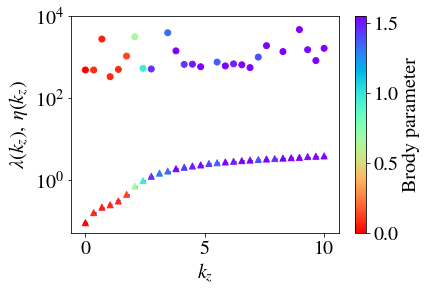

In [47]:
plt.figure()
cmap1=mpl.cm.get_cmap("rainbow_r")
plt.errorbar(k_arr, eta_k, yerr=std_eta_k, ls='None', capsize=2, color='black', zorder=0)
plt.errorbar(k_arr, lyap_k, yerr=std_lyap_k, ls='None', capsize=2, color='blue', zorder=0)
plt.scatter(k_arr, lyap_k, c=brody_p, vmin=0, vmax=1.55, marker="^", cmap=cmap1)
plt.scatter(k_arr, eta_k, c=brody_p, vmin=0, vmax=1.55, cmap=cmap1)
cb=plt.colorbar()
cb.set_label("Brody parameter")
plt.yscale('log')
plt.ylim(5e-2, 1e4)
plt.xlabel("$k_z$")
plt.ylabel(r"$\lambda(k_z), \; \eta(k_z)$")
plt.show()

In [46]:
"""plt.figure()
plt.scatter(lyap_k, eta_k, c=brody_p)
plt.yscale('log')
plt.show()"""

"plt.figure()\nplt.scatter(lyap_k, eta_k, c=brody_p)\nplt.yscale('log')\nplt.show()"